# Facial Keypoints - Model Training

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from facepoint.models import Net

net = Net()
# net.cuda() # Transformations are Cuda Tensors now ..
# torch.set_default_tensor_type('torch.cuda.FloatTensor')

print(net)

Net(
  (conv1): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 8, kernel_size=(4, 4), stride=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(16, 24, kernel_size=(2, 2), stride=(1, 1))
  (drop1): Dropout(p=0.1, inplace=False)
  (drop2): Dropout(p=0.2, inplace=False)
  (drop3): Dropout(p=0.3, inplace=False)
  (drop4): Dropout(p=0.4, inplace=False)
  (drop5): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=3456, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=136, bias=True)
)


In [3]:
# Define a Data Transform
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from facepoint.data_load import FacialKeypointsDataset
from facepoint.data_load import Rescale, RandomCrop, Normalize, ToTensor

data_transform = transforms.Compose([Rescale(250), RandomCrop(224), Normalize(), ToTensor()])

In [4]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


# print('Number of images: ', len(transformed_dataset))

# # iterate through the transformed dataset and print some stats about the first few samples
# for i in range(4):
#     sample = transformed_dataset[i]
#     print(i, sample['image'].size(), sample['keypoints'].size())

In [11]:
# load training data in batches
batch_size = 32

from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(range(2770)) # about 80% of the training images 
validation_sampler = SubsetRandomSampler(range(2771,len(transformed_dataset)))

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          num_workers=0,
                          sampler=train_sampler)

# Create a Validation Set. ( It seems that we can't use data/test for validation as they are copies from the training data)
validation_loader = DataLoader(transformed_dataset, 
                               batch_size=batch_size,
                               num_workers=0,
                               sampler=validation_sampler)

In [12]:




# Load Test set

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)


# load test data in batches
batch_size = 32
test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


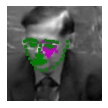

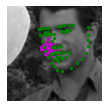

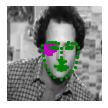

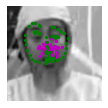

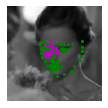

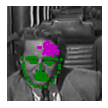

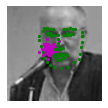

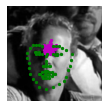

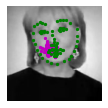

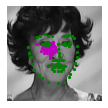

In [13]:
from facepoint.utils import visualize_output, net_sample_output

test_images, test_outputs, gt_pts = net_sample_output(test_loader, net)
visualize_output(test_images, test_outputs, gt_pts)

In [14]:
# Do the Training ... 

import torch.optim as optim

criterion = nn.MSELoss()

optimizer = optim.Adam(net.parameters(), lr=0.001)


#Initialize Weights
for param in net.parameters():
    if(param.dim() > 1):
        nn.init.xavier_normal_(param)   
        

In [19]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        for phase, data_loader in [("train", train_loader), ("evaln", validation_loader)]:
            if(phase == "train"):
                net.train()
            else:
                net.eval()
                
            running_loss = 0.0    
            num_images = 0
            # train on batches of data, assumes you already have train_loader
            for batch_i, data in enumerate(data_loader):
                # get the input images and their corresponding labels
                images = data['image']
                key_pts = data['keypoints']

                # flatten pts
                key_pts = key_pts.view(key_pts.size(0), -1)

                # convert variables to floats for regression loss
                #key_pts = key_pts.type(torch.cuda.FloatTensor)
                #images = images.type(torch.cuda.FloatTensor)
                key_pts = key_pts.type(torch.FloatTensor)
                images = images.type(torch.FloatTensor)
                # forward pass to get outputs
                output_pts = net(images)

                # calculate the loss between predicted and target keypoints
                loss = criterion(output_pts, key_pts)

                if(phase == "train"):
                    # zero the parameter (weight) gradients
                    optimizer.zero_grad()

                    # backward pass to calculate the weight gradients
                    loss.backward()

                    # update the weights
                    optimizer.step()


                running_loss += loss.item()
                num_images += len(images)
            # print loss statistics
            print('Epoch: {}, Phase: {}, Loss: {}'.format(epoch+1, phase, 100*running_loss/num_images))
        print("\n")
        
    print('Finished Training')


In [20]:
# train your network
n_epochs = 10
train_net(n_epochs)

Epoch: 1, Phase: train, Loss: 0.8260066350014201
Epoch: 1, Phase: evaln, Loss: 0.7769172059644321


Epoch: 2, Phase: train, Loss: 0.6392753753636288
Epoch: 2, Phase: evaln, Loss: 0.7220027092224265


Epoch: 3, Phase: train, Loss: 0.610108708001216
Epoch: 3, Phase: evaln, Loss: 0.6883406626160341


Epoch: 4, Phase: train, Loss: 0.62068930171457
Epoch: 4, Phase: evaln, Loss: 0.6651128188055953


Epoch: 5, Phase: train, Loss: 0.5898258326716371
Epoch: 5, Phase: evaln, Loss: 0.6341024629459022


Epoch: 6, Phase: train, Loss: 0.597424494768308
Epoch: 6, Phase: evaln, Loss: 0.6882060346141048


Epoch: 7, Phase: train, Loss: 0.6007518509019583
Epoch: 7, Phase: evaln, Loss: 0.6530798098285361


Epoch: 8, Phase: train, Loss: 0.6178458806947681
Epoch: 8, Phase: evaln, Loss: 0.586520771559344


Epoch: 9, Phase: train, Loss: 0.6008747784884828
Epoch: 9, Phase: evaln, Loss: 0.6181439834979785


Epoch: 10, Phase: train, Loss: 0.5939004142577037
Epoch: 10, Phase: evaln, Loss: 0.7103020910243739


Fin

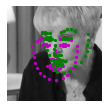

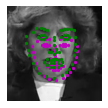

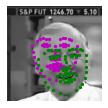

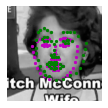

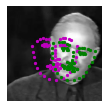

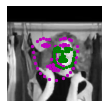

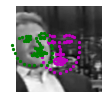

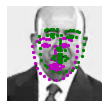

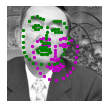

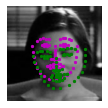

In [22]:
# Test on some sample data
test_images, test_outputs, gt_pts = net_sample_output(test_loader, net)
visualize_output(test_images, test_outputs, gt_pts)

In [ ]:
# Save model

model_dir = 'saved_models'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)